In [1]:
import os
import numpy as np
import tqdm
import json
import random
import time
import multiprocessing
from ember_features import PEFeatureExtractor
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
import copy
import matplotlib.pyplot as plt
import scipy as stats
from sklearn.manifold import TSNE
from collections import defaultdict

plt.rcParams['font.size'] = 18
#plt.rcParams['font.family'] = "serif"
tdir = 'in'
major = 5.0
minor = 3.0
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor

np.random.RandomState(42);

In [2]:
all_task_months = ['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
                   '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12']

malware_family_sample_count = {}
goodware_family_sample_count = {}

malware_family_samples = {}

others_family = {}

for task in range(0,len(all_task_months)):
    
    current_task = all_task_months[task]
    task_months = all_task_months[:task+1]
    
    
    save_dir = '/home/mr6564/continual_research/month_based_processing_with_family_labels/' + str(current_task) + '/'
    
    print(f'Processing data for task {current_task}')
    Y_family_labels_file = save_dir + 'task_family_labels.npz'
    Y_fam_labels_ = np.load(Y_family_labels_file)
    Y_fam_labels = Y_fam_labels_['family_labels']

    y_path = os.path.join(save_dir, "y_train.dat")
    X_path = os.path.join(save_dir, "X_train.dat")
    
    
    y_ = np.memmap(y_path, dtype=np.float32, mode="r")
    N = y_.shape[0]
    
    ndim = 2381
    X_ = np.memmap(X_path, dtype=np.float32, mode="r", shape=(N, ndim))    
    #print(np.unique(y_))
    
#     Y_family_labels_file = save_dir + 'task_family_labels.npz'
#     Y_fam_labels_ = np.load(Y_family_labels_file)
#     Y_fam_labels = Y_fam_labels_['family_labels']
    
    
    goodware_indices = []
    malware_indices = []
    
    others_family_samples = []
    
    malware_task_family_samples = defaultdict(list)
    
    for ind, i in enumerate(y_):
        if i == 0:
            goodware_indices.append(ind)
        elif i == 1:
            malware_indices.append(ind)
            if Y_fam_labels[ind] == '':
                others_family_samples.append(X_[ind])
            else:
                malware_task_family_samples[Y_fam_labels[ind]].append(X_[ind])
                #if Y_fam_labels[ind] not in malware_task_family_samples.keys():
                #    malware_task_family_samples[Y_fam_labels[ind]]= X_ind
                #else:
                #    malware_task_family_samples[Y_fam_labels[ind]].append(X_ind)
        else:
            pass
    
    malware_family_samples[task] = malware_task_family_samples
    others_family[task] = others_family_samples
    

    Y_families_malware = Y_fam_labels[malware_indices]
    Y_families_goodware = Y_fam_labels[goodware_indices]
    
    
    
    for yfam in Y_families_malware:
        if yfam in malware_family_sample_count.keys():
            malware_family_sample_count[yfam] += 1
        else:
            malware_family_sample_count[yfam] = 1
    
    
    for yfam in Y_families_goodware:
        if yfam in goodware_family_sample_count.keys():
            goodware_family_sample_count[yfam] += 1
        else:
            goodware_family_sample_count[yfam] = 1
            

print(len(malware_family_sample_count.keys()), len(goodware_family_sample_count.keys()))


Processing data for task 2018-01
Processing data for task 2018-02
Processing data for task 2018-03
Processing data for task 2018-04
Processing data for task 2018-05
Processing data for task 2018-06
Processing data for task 2018-07
Processing data for task 2018-08
Processing data for task 2018-09
Processing data for task 2018-10
Processing data for task 2018-11
Processing data for task 2018-12
2900 1


In [ ]:
def read_task_based_vectorized_features(save_dir):
    """
    Read vectorized features into memory mapped numpy arrays
    """
    ndim = 2381
    X_ = None
    y_ = None


    X_path = os.path.join(save_dir, "X_train.dat")
    y_path = os.path.join(save_dir, "y_train.dat")
    
    y_ = np.memmap(y_path, dtype=np.float32, mode="r")
    N = y_.shape[0]
    
    X_ = np.memmap(X_path, dtype=np.float32, mode="r", shape=(N, ndim))
    
    print(np.unique(y_))
    
    goodware_indices = []
    malware_indices = []
    
    
    for ind, i in enumerate(y_):
        if i == 0:
            goodware_indices.append(ind)
        elif i == 1:
            malware_indices.append(ind)
        else:
            pass
    
    malware_goodware_indices = goodware_indices + malware_indices
    
    print(len(y_[malware_goodware_indices]), len(y_[goodware_indices]), len(y_[malware_indices]))
    
    
    Y_family_labels_file = save_dir + 'task_family_labels.npz'
    Y_fam_labels_ = np.load(Y_family_labels_file)
    Y_fam_labels = Y_fam_labels_['family_labels']
    
    
    
    X = X_[malware_goodware_indices]
    Y = y_[malware_goodware_indices]
    Y_families = Y_fam_labels[malware_goodware_indices]
    
    indx = [i for i in range(len(Y))]
    random.shuffle(indx)

    train_size = int(len(indx)*0.9)
    trainset = indx[:train_size]
    testset = indx[train_size:]

    # Separate the training set
    X_train = X[trainset]
    Y_train = Y[trainset]
    Y_family_train = Y_families[trainset]

    # Separate the test set
    X_test = X[testset]
    Y_test = Y[testset]
    Y_family_test = Y_families[testset]
    
    
    print(f'X_train {X_train.shape} Y_train {Y_train.shape} Y_family_train {Y_family_train.shape}\n X_test {X_test.shape} Y_test {Y_test.shape} \n Y_family_test {Y_family_test.shape}')
    
    print(f'saving files ...')
    save_training_file = save_dir + 'XY_train.npz'
    save_test_file = save_dir + 'XY_test.npz'
    
    np.savez(save_training_file, X_train=X_train, Y_train=Y_train, Y_family_train = Y_family_train)
    np.savez(save_test_file, X_test=X_test, Y_test=Y_test, Y_family_test = Y_family_test)


In [ ]:
all_task_months = ['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
                   '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12']

data_dir = "../../../ember/ember_data/2018_data/ember2018/"

for task in range(0,len(all_task_months)):
    start_time = time.time()
    #task = 5 + task
    current_task = all_task_months[task]
    task_months = all_task_months[:task+1]
    
    save_dir = '../../ember2018/month_based_processing_with_family_labels_strict/' + str(current_task) + '/'
    create_parent_folder(save_dir)
    
    print(f'Processing data for task {current_task}')
    #print(current_task, task_months)
    read_task_based_vectorized_features(save_dir, feature_version=2)
    
    
    end_time = time.time()
    
    print(f'Elapsed time {(end_time - start_time)/60} mins.')    

In [28]:
def get_month_data(data_dir, month, train=True):
    
    if train:
        data_dir = data_dir + str(month) + '/'
        XY_train = np.load(data_dir + 'XY_train.npz')
        X_tr, Y_tr = XY_train['X_train'], XY_train['Y_train']
        assert len(Y_tr) == len(X_tr)
        print(len(Y_tr))
        return X_tr, Y_tr
    else:
        data_dir = data_dir + str(month) + '/'
        XY_test = np.load(data_dir + 'XY_test.npz')
        X_test, Y_test = XY_test['X_test'], XY_test['Y_test']
        assert len(X_test) == len(Y_test)
        print(len(Y_test))
        return X_test, Y_test 

X_model, Y_model = get_month_data('../../../month_based_processing_with_family_labels/', str(all_task_months[0]), train=True)
X_model, Y_model = get_month_data('../../../month_based_processing_with_family_labels/', str(all_task_months[0]), train=False)

55722
6192


In [18]:
save_dir = '../../../month_based_processing_with_family_labels/' + str(all_task_months[0]) + '/'

ndim = 2381
X_ = None
y_ = None


X_path = os.path.join(save_dir, "X_train.dat")
y_path = os.path.join(save_dir, "y_train.dat")

y_ = np.memmap(y_path, dtype=np.float32, mode="r")
N = y_.shape[0]

X_ = np.memmap(X_path, dtype=np.float32, mode="r", shape=(N, ndim))

print(np.unique(y_))

X, Y = X_, y_

[-1.  0.  1.]


In [21]:
len(X_), len(y_)

(84702, 84702)

In [24]:
for task, task_samples in malware_family_samples.items():
    #print(task)
    cnt = 0
    if task == 0:
        for task_family, family_samples in task_samples.items():
            for f in family_samples:
                cnt += 1
    print(cnt)

30723
0
0
0
0
0
0
0
0
0
0
0


In [4]:
malware_counts_task_family = {}

family_lists = []

for task, task_samples in malware_family_samples.items():
    #print(task)
    if task == 0:
        #print(task_samples)
        learned_families = 0
        new_families = 0
        for task_family, family_samples in task_samples.items():
            if task_family != 0:
                #print(task_family, len(family_samples))
                if task_family not in family_lists:
                    new_families += 1
                    family_lists.append(task_family)
                    
        malware_counts_task_family[task] = (learned_families, new_families)
    else:
        learned_families = 0
        new_families = 0
        for task_family, family_samples in task_samples.items():
            if task_family != 0:
                #print(task_family, len(family_samples))
                if task_family not in family_lists:
                    new_families += 1
                    family_lists.append(task_family)
                else:
                    learned_families += 1
                    
        malware_counts_task_family[task] = (learned_families, new_families)

In [10]:
malware_counts_task_family, len(family_lists)

({0: (0, 913),
  1: (551, 425),
  2: (641, 257),
  3: (596, 208),
  4: (726, 183),
  5: (761, 184),
  6: (658, 118),
  7: (784, 133),
  8: (873, 287),
  9: (370, 23),
  10: (508, 66),
  11: (652, 102)},
 2899)

In [28]:
learned_families_all = [v[0] for k, v in malware_counts_task_family.items()]
new_families_all = [v[1] for k, v in malware_counts_task_family.items()]
print(learned_families_all, new_families_all)

[0, 551, 641, 596, 726, 761, 658, 784, 873, 370, 508, 652] [913, 425, 257, 208, 183, 184, 118, 133, 287, 23, 66, 102]


In [45]:
for ind in range(len(learned_families_all)):
    
    print(learned_families_all[ind], new_families_all[ind])

0 913
551 425
641 257
596 208
726 183
761 184
658 118
784 133
873 287
370 23
508 66
652 102


In [47]:
def compute(a, b, c):
    return a + b - c

#jan
compute(0, 913, 551)

# feb 551 + 425 - 641
compute(551, 425, 641)

#march 
compute(641, 257, 596)

#april
compute(596, 208, 726)

#may
compute(726, 183, 761)

#june
compute(761, 185, 658)

#july
compute(658, 118, 784)

#august
compute(784, 133, 873)

#september
compute(873, 287, 370)

#october
compute(370, 23, 508)

#november
compute(508, 66, 652)

#december
compute(652, 102, 0)


754

In [54]:
compute(0, 913, 551)

362

In [49]:
len(learned_families_all)

12

In [57]:
losts = [0, ]

current = 913
for ind in range(len(learned_families_all) -1 ):
    #print(ind)
    lost = current - learned_families_all[ind+1]
    current = learned_families_all[ind+1] + new_families_all[ind+1]
    
    #print(current, lost)
    if abs(lost)/lost == -1: 
        losts.append(0)
    else:
        losts.append(lost)
print(losts)


[0, 362, 335, 302, 78, 148, 287, 0, 44, 790, 0, 0]


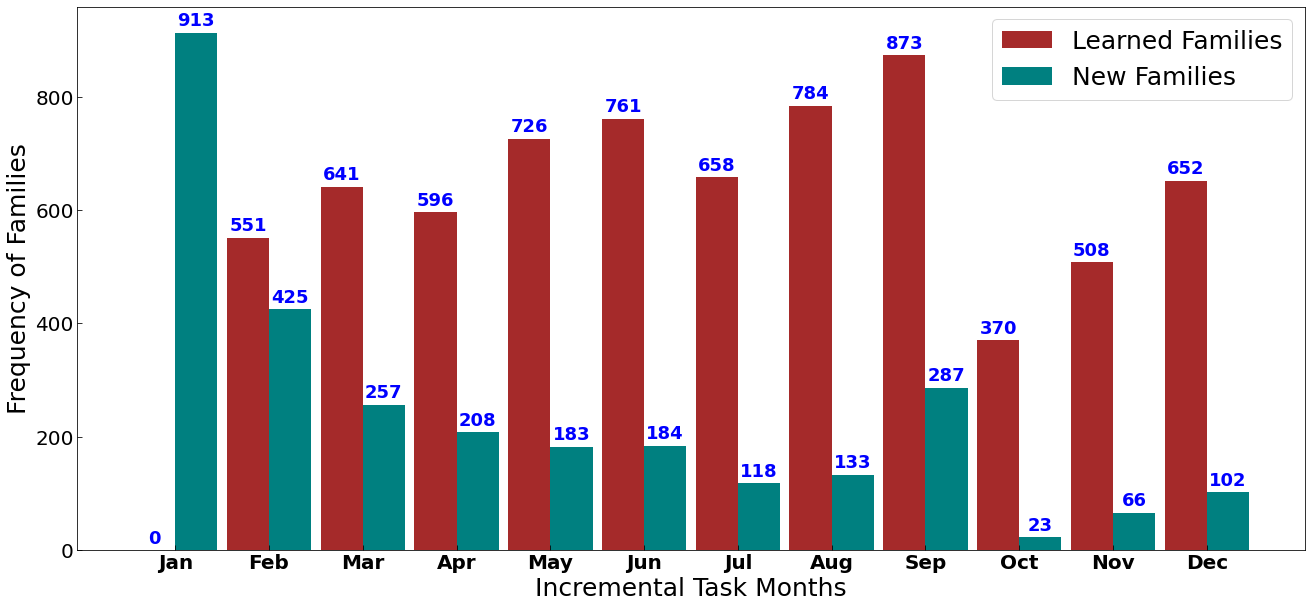

In [59]:
save_file_name = f'malware_family_counts_by_task.pdf'


tasksmonths = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


x = np.arange(len(tasksmonths))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots(figsize=(22, 10))
learned = ax.bar(x - width/2, learned_families_all, width, label='Learned Families', color='brown')
new = ax.bar(x + width/2, new_families_all, width, label='New Families', color='teal')


ax.bar_label(learned, padding=3, color='blue', fontweight ='bold',fontsize=18)
ax.bar_label(new, padding=3, color='blue', fontweight ='bold',fontsize=18)

ax.legend(fontsize=25)
plt.xticks(x, tasksmonths, fontsize=20, fontweight ='bold');
plt.yticks(fontsize=20);
plt.xlabel(f'Incremental Task Months', fontsize=25)
plt.ylabel(f'Frequency of Families', fontsize=25)
 
#title of plot
#plt.title(f'EMBER 2018 - NO AVCLASS Labels SAMPLES', fontsize=30);

#plt.grid(True, linestyle='--', linewidth=1.)
plt.savefig('./figures/' + save_file_name, bbox_inches='tight', transparent=True);

In [ ]:
top_10 = top_100_key[:100]

print(top_10)

In [ ]:
malware_family_samples.keys()

In [ ]:
print(top_10)
top_10_families = {}

for month, data in malware_family_samples.items():
    for k, v in data.items():
        if k in top_10:
            if k not in top_10_families.keys():
                top_10_families[k] = v
            else:
                top_10_families[k] = np.concatenate((top_10_families[k], v))
                

In [ ]:
len(top_10_families['xtrat'])

In [ ]:
len(malware_family_sample_count.keys())

In [ ]:
num_others = []
for k, v in others_family.items():
    print(len(v))
    num_others.append(len(v))

print(sum(num_others))

In [21]:
all_others = np.concatenate(([v for k, v in others_family.items()]))

In [ ]:
len(all_others)

In [ ]:
ramnit = malware_family_sample_count['ramnit']
print(ramnit)

In [ ]:

data_X = top_10_families['xtrat']

# fit the model
clf = IsolationForest(max_samples=len(data_X))
clf.fit(data_X)
scores_prediction = clf.decision_function(data_X)
#y_pred_train = clf.predict(all_others)

In [ ]:
len(scores_prediction[np.where(scores_prediction >= 0.15)])

In [ ]:
top_10

In [ ]:
top_10

In [ ]:
def get_isolation_forest_scores(family_index, top_families_name, top_families_data):
    
    if family_index == 'others_family':
        print(f'family name {family_index}')
        data_X = all_others #top_10_families[top_10[top_ind]]
    else:
        print(f'family name {top_families_name[family_index]}')
        data_X = top_families_data[top_families_name[family_index]]
        #top_10_families[top_10[top_ind]]
        
        
    # fit the model
    clf = IsolationForest(max_samples=len(data_X))
    clf.fit(data_X)
    scores_prediction = clf.decision_function(data_X)
    y_pred = clf.predict(all_others)
    
    return scores_prediction, y_pred

In [ ]:
anomaly_others = get_isolation_forest_scores('others_family', top_10, top_10_families)

In [ ]:
anomaly_0 = get_isolation_forest_scores(0, top_10, top_10_families)

In [ ]:
anomaly_1, y_pred_1 = get_isolation_forest_scores(1, top_10, top_10_families)

In [ ]:
anomaly_1[np.where(anomaly_1 <= 0.0)], y_pred_1[np.where(y_pred_1 == -1)]

anomalous_samples = np.where(y_pred_1 == -1.0)
similar_samples = np.where(y_pred_1 == 1.0)

print(f'all-{len(y_pred_1)} anom-{len(anomalous_samples[0])} sim-{len(similar_samples[0])}')
len(anomalous_samples[0]) + len(similar_samples[0]) == len(y_pred_1)

In [ ]:
print(type(anomalous_samples)), print(type(top_10_families[top_10[1]]))

In [ ]:

len(top_10_families[top_10[1]][anomalous_samples])

In [ ]:
anomaly_2 = get_isolation_forest_scores(2, top_10, top_10_families)
anomaly_3 = get_isolation_forest_scores(3, top_10, top_10_families)
anomaly_4 = get_isolation_forest_scores(4, top_10, top_10_families)
anomaly_5 = get_isolation_forest_scores(5, top_10, top_10_families)
anomaly_6 = get_isolation_forest_scores(6, top_10, top_10_families)
anomaly_7 = get_isolation_forest_scores(7, top_10, top_10_families)

In [ ]:
save_file_name = 'kdeplot_anomaly_scores_top_9.png'
figure, axis = plt.subplots(3, 3, figsize=(18, 12))

figure.suptitle('KDE Plot of Anomaly Scores of Top 9 Malware Families')
#figure.supxlabel("Anomaly Scores", fontsize=15)
#figure.supylabel("Density", fontsize=15)   


sns.kdeplot(ax=axis[0, 0], data=anomaly_others, shade=True, color="blue", linewidth=4)
axis[0, 0].set_title(f"Others Family - {len(anomaly_others)} samples", fontsize=15)
axis[0, 0].tick_params(labelsize=15)  
#axis[0, 0].set_xlabel("Anomaly Scores",fontsize=15)    
axis[0, 0].set_ylabel("Density",fontsize=15)    
axis[0, 0].set_xlim(-0.5, 0.5)
axis[0, 0].set_ylim(0, 120)


sns.kdeplot(ax=axis[0, 1], data=anomaly_0, shade=True, color="blue", linewidth=4)
axis[0, 1].set_title(f'{[top_10[0]][0]} - {len(anomaly_0)} samples', fontsize=15)
axis[0, 1].tick_params(labelsize=15)  
#axis[0, 1].set_xlabel("Anomaly Scores",fontsize=15)    
axis[0, 1].set_ylabel(" ",fontsize=15)    
axis[0, 1].set_xlim(-0.5, 0.5)  
axis[0, 1].set_ylim(0, 120)


sns.kdeplot(ax=axis[0, 2], data=anomaly_1, shade=True, color="blue", linewidth=4)
axis[0, 2].set_title(f'{[top_10[1]][0]} - {len(anomaly_1)} samples', fontsize=15)
axis[0, 2].tick_params(labelsize=15)  
#axis[0, 2].set_xlabel("Anomaly Scores",fontsize=15)    
axis[0, 2].set_ylabel(" ",fontsize=15)    
axis[0, 2].set_xlim(-0.5, 0.5)
axis[0, 2].set_ylim(0, 120)



sns.kdeplot(ax=axis[1, 0], data=anomaly_2, shade=True, color="blue", linewidth=4)
axis[1, 0].set_title(f'{[top_10[2]][0]} - {len(anomaly_2)} samples', fontsize=15)
axis[1, 0].tick_params(labelsize=15)  
#axis[1, 0].set_xlabel("Anomaly Scores",fontsize=15)    
axis[1, 0].set_ylabel("Density",fontsize=15) 
axis[1, 0].set_xlim(-0.5, 0.5)
axis[1, 0].set_ylim(0, 120)


sns.kdeplot(ax=axis[1, 1], data=anomaly_3, shade=True, color="blue", linewidth=4)
axis[1, 1].set_title(f'{[top_10[3]][0]} - {len(anomaly_3)} samples', fontsize=15)
axis[1, 1].tick_params(labelsize=15)  
#axis[1, 1].set_xlabel("Anomaly Scores",fontsize=15)    
axis[1, 1].set_ylabel(" ",fontsize=15) 
axis[1, 1].set_xlim(-0.5, 0.5)  
axis[1, 1].set_ylim(0, 120)



sns.kdeplot(ax=axis[1, 2], data=anomaly_4, shade=True, color="blue", linewidth=4)
axis[1, 2].set_title(f'{[top_10[4]][0]} - {len(anomaly_4)} samples', fontsize=15)
axis[1, 2].tick_params(labelsize=15)  
#axis[1, 2].set_xlabel("Anomaly Scores",fontsize=15)    
axis[1, 2].set_ylabel(" ",fontsize=15) 
axis[1, 2].set_xlim(-0.5, 0.5)
axis[1, 2].set_ylim(0, 120)



sns.kdeplot(ax=axis[2, 0], data=anomaly_5, shade=True, color="blue", linewidth=4)
axis[2, 0].set_title(f'{[top_10[5]][0]} - {len(anomaly_5)} samples', fontsize=15)
axis[2, 0].tick_params(labelsize=15)  
axis[2, 0].set_xlabel("Anomaly Scores",fontsize=15)    
axis[2, 0].set_ylabel("Density",fontsize=15) 
axis[2, 0].set_xlim(-0.5, 0.5)
axis[2, 0].set_ylim(0, 120)



sns.kdeplot(ax=axis[2, 1], data=anomaly_6, shade=True, color="blue", linewidth=4)
axis[2, 1].set_title(f'{[top_10[6]][0]} - {len(anomaly_6)} samples', fontsize=15)
axis[2, 1].tick_params(labelsize=15)  
axis[2, 1].set_xlabel("Anomaly Scores",fontsize=15)    
axis[2, 1].set_ylabel(" ",fontsize=15) 
axis[2, 1].set_xlim(-0.5, 0.5)
axis[2, 1].set_ylim(0, 120)



sns.kdeplot(ax=axis[2, 2], data=anomaly_7, shade=True, color="blue", linewidth=4)
axis[2, 2].set_title(f'{[top_10[7]][0]} - {len(anomaly_7)} samples', fontsize=15)
axis[2, 2].tick_params(labelsize=15)  
axis[2, 2].set_xlabel("Anomaly Scores",fontsize=15)    
axis[2, 2].set_ylabel(" ",fontsize=15) 
axis[2, 2].set_xlim(-0.5, 0.5)
axis[2, 2].set_ylim(0, 120)



#plt.tick_params(labelcolor="none", bottom=False, left=False)


plt.subplots_adjust(hspace = 0.3)

plt.savefig('./figures/isolation_forest/' + save_file_name,
                bbox_inches='tight');


In [ ]:

sns.color_palette()
save_file_name = 'scatter_anomaly_scores_top_9.png'
figure, axis = plt.subplots(3, 3, figsize=(18, 12))

figure.suptitle('Scatter Plot of Anomaly Scores of Top 9 Malware Families')
#figure.supxlabel("Anomaly Scores", fontsize=15)
#figure.supylabel("Density", fontsize=15)   



sns.scatterplot(ax=axis[0, 0], x=anomaly_others, y=[i for i in range(len(anomaly_others))], color='green', s=100)
axis[0, 0].set_title(f"Others Family - {len(anomaly_others)} samples", fontsize=15)
axis[0, 0].tick_params(labelsize=15)  
#axis[0, 0].set_xlabel("Anomaly Scores",fontsize=15)    
axis[0, 0].set_ylabel("Index of Samples",fontsize=15)    
axis[0, 0].set_xlim(-0.5, 0.5)
axis[0, 0].set_ylim(0, 40000)


sns.scatterplot(ax=axis[0, 1], x=anomaly_0, y=[i for i in range(len(anomaly_0))], color='green', s=100)
axis[0, 1].set_title(f'{[top_10[0]][0]} - {len(anomaly_0)} samples', fontsize=15)
axis[0, 1].tick_params(labelsize=15)  
#axis[0, 1].set_xlabel("Anomaly Scores",fontsize=15)    
axis[0, 1].set_ylabel(" ",fontsize=15)    
axis[0, 1].set_xlim(-0.5, 0.5)  
axis[0, 1].set_ylim(0, 40000)


sns.scatterplot(ax=axis[0, 2], x=anomaly_1, y=[i for i in range(len(anomaly_1))], color='green', s=100)
axis[0, 2].set_title(f'{[top_10[1]][0]} - {len(anomaly_1)} samples', fontsize=15)
axis[0, 2].tick_params(labelsize=15)  
#axis[0, 2].set_xlabel("Anomaly Scores",fontsize=15)    
axis[0, 2].set_ylabel(" ",fontsize=15)    
axis[0, 2].set_xlim(-0.5, 0.5)
axis[0, 2].set_ylim(0, 40000)


sns.scatterplot(ax=axis[1, 0], x=anomaly_2, y=[i for i in range(len(anomaly_2))], color='green', s=100)
axis[1, 0].set_title(f'{[top_10[2]][0]} - {len(anomaly_2)} samples', fontsize=15)
axis[1, 0].tick_params(labelsize=15)  
#axis[1, 0].set_xlabel("Anomaly Scores",fontsize=15)    
axis[1, 0].set_ylabel("Index of Samples",fontsize=15) 
axis[1, 0].set_xlim(-0.5, 0.5)
axis[1, 0].set_ylim(0, 40000)


sns.scatterplot(ax=axis[1, 1], x=anomaly_3, y=[i for i in range(len(anomaly_3))], color='green', s=100)
axis[1, 1].set_title(f'{[top_10[3]][0]} - {len(anomaly_3)} samples', fontsize=15)
axis[1, 1].tick_params(labelsize=15)  
#axis[1, 1].set_xlabel("Anomaly Scores",fontsize=15)    
axis[1, 1].set_ylabel(" ",fontsize=15) 
axis[1, 1].set_xlim(-0.5, 0.5)  
axis[1, 1].set_ylim(0, 40000)



sns.scatterplot(ax=axis[1, 2], x=anomaly_4, y=[i for i in range(len(anomaly_4))], color='green', s=100)
axis[1, 2].set_title(f'{[top_10[4]][0]} - {len(anomaly_4)} samples', fontsize=15)
axis[1, 2].tick_params(labelsize=15)  
#axis[1, 2].set_xlabel("Anomaly Scores",fontsize=15)    
axis[1, 2].set_ylabel(" ",fontsize=15) 
axis[1, 2].set_xlim(-0.5, 0.5)
axis[1, 2].set_ylim(0, 40000)


sns.scatterplot(ax=axis[2, 0], x=anomaly_5, y=[i for i in range(len(anomaly_5))], color='green', s=100)
sns.kdeplot(ax=axis[2, 0], data=anomaly_5, shade=True, color="blue", linewidth=4)
axis[2, 0].set_title(f'{[top_10[5]][0]} - {len(anomaly_5)} samples', fontsize=15)
axis[2, 0].tick_params(labelsize=15)  
axis[2, 0].set_xlabel("Anomaly Scores",fontsize=15)    
axis[2, 0].set_ylabel("Index of Samples",fontsize=15) 
axis[2, 0].set_xlim(-0.5, 0.5)
axis[2, 0].set_ylim(0, 40000)



sns.scatterplot(ax=axis[2, 1], x=anomaly_6, y=[i for i in range(len(anomaly_6))], color='green', s=100)
axis[2, 1].set_title(f'{[top_10[6]][0]} - {len(anomaly_6)} samples', fontsize=15)
axis[2, 1].tick_params(labelsize=15)  
axis[2, 1].set_xlabel("Anomaly Scores",fontsize=15)    
axis[2, 1].set_ylabel(" ",fontsize=15) 
axis[2, 1].set_xlim(-0.5, 0.5)
axis[2, 1].set_ylim(0, 40000)


sns.scatterplot(ax=axis[2, 2], x=anomaly_7, y=[i for i in range(len(anomaly_7))], color='green', s=100)
axis[2, 2].set_title(f'{[top_10[7]][0]} - {len(anomaly_7)} samples', fontsize=15)
axis[2, 2].tick_params(labelsize=15)  
axis[2, 2].set_xlabel("Anomaly Scores",fontsize=15)    
axis[2, 2].set_ylabel(" ",fontsize=15) 
axis[2, 2].set_xlim(-0.5, 0.5)
axis[2, 2].set_ylim(0, 40000)



#plt.tick_params(labelcolor="none", bottom=False, left=False)


plt.subplots_adjust(hspace = 0.3)

plt.savefig('./figures/isolation_forest/' + save_file_name,
                bbox_inches='tight');


In [ ]:


family_name = 'others_family' #top_10[top_ind] #'others_family'

save_file_name = family_name +'.png'

plt.figure(figsize=(12, 8))

plt.scatter(scores_prediction, [i for i in range(len(scores_prediction))], s=50 ,c="green");

plt.xticks(fontsize=25);
plt.yticks(fontsize=25);
plt.xlabel(f'Anomaly Scores', fontsize=25)
plt.ylabel(f'#of Samples', fontsize=25)


plt.title(f"{family_name} has {len(scores_prediction)} Samples", fontsize=30)
plt.savefig('./figures/isolation_forest/' + save_file_name,
                bbox_inches='tight');


In [ ]:
tasksmonths = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

    
tsne = TSNE(random_state=123)
embedded = tsne.fit_transform(all_others)

sns.set (style = 'white', color_codes = True, 
         palette = ["#FF0000", "#0000FF", "#00FF00", "#C03030", "#3030C0", "#30C030"])

save_file_name = f'allmonths_others_family.png'


fig, axes = plt.subplots(1, 1, figsize=(10, 10), sharey=True)

sns.scatterplot(ax=axes, x=embedded[:,0],\
                y=embedded[:,1], legend=True,
                alpha=1);


plt.title(f"January to December", fontsize=30)
plt.savefig('./figures/others_family/' + save_file_name,
                bbox_inches='tight');
plt.show()

In [ ]:
Y_families_malware

In [ ]:
goodware_family_sample_count.values(), sum(malware_family_sample_count.values())

In [ ]:
#malware_family_sample_count['others_family'] = malware_family_sample_count[''] 
#del malware_family_sample_count[''] 

In [ ]:
#11433
print(malware_family_sample_count['others_family'])
print(sum(malware_family_sample_count.values()))

In [ ]:
sorted_dict = dict(sorted(malware_family_sample_count.items(), key=lambda item: item[1], reverse=True))

In [ ]:
top_k = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 20000, 30000]

for j in top_k:
    cnt = 0
    for k, v in malware_family_sample_count.items():
        if v <= j:
            cnt += 1

    print(f'#of families with {j} samples are {cnt}')
    

In [ ]:
top_100_val = []
top_100_key = []
top_100 = {}

cnt_f = 0
for k, v in sorted_dict.items():
    if cnt_f == 100:
        break
    
    top_100_val.append(v)
    top_100_key.append(k)
    top_100[k] = v
    cnt_f += 1
    

In [ ]:
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

save_file_name = f'Top_50_families_EMBER_2018.png'

sns.set(rc={'figure.figsize':(30, 12)})

plt.bar(top_100_key[:50], top_100_val[:50], color='blue')
plt.xticks(rotation=90, fontsize=25);
plt.yticks(fontsize=25);
plt.xlabel(f'Top 50 Malware Families', fontsize=25)
plt.ylabel(f'#of Samples', fontsize=25)
 
# title of plot
plt.title(f'EMBER 2018 - Top 50 Malware Families in the Dataset', fontsize=30);

#plt.grid(True, linestyle='--', linewidth=1.)
plt.savefig('./figures/' + save_file_name,
                bbox_inches='tight');

In [ ]:
# Add exemplars (if available) to current dataset (if requested)
if add_exemplars and task>1:
    target_transform = (lambda y, x=classes_per_task: y%x) if scenario=="domain" else None
    exemplar_dataset = ExemplarDataset(model.exemplar_sets, target_transform=target_transform)
    training_dataset = ConcatDataset([train_dataset, exemplar_dataset])
else:
    training_dataset = train_dataset


# <CL Training Procedure>



# EXEMPLARS: update exemplar sets
if (add_exemplars or use_exemplars) or replay_mode=="exemplars":
    exemplars_per_class = int(np.floor(model.memory_budget / (classes_per_task*task)))
    # reduce examplar-sets
    model.reduce_exemplar_sets(exemplars_per_class)
    # for each new class trained on, construct examplar-set
    new_classes = list(range(classes_per_task)) if scenario=="domain" else list(range(classes_per_task*(task-1),
                                                                                      classes_per_task*task))
    for class_id in new_classes:
        # create new dataset containing only all examples of this class
        class_dataset = SubDataset(original_dataset=train_dataset, 
                                   orig_length_features=2492,\
                                   target_length_features=2500,\
                                   sub_labels=[class_id])
        # based on this dataset, construct new exemplar-set for this class
        model.construct_exemplar_set(dataset=class_dataset, n=exemplars_per_class)
    model.compute_means = True